In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
import keras

In [ ]:
import keras.backend as K
def focal_loss(gamma=2., alpha=.25, coeff=1):

  def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return (-K.sum(alpha*K.pow(1.-pt_1, gamma)*K.log(K.mean(pt_1))) - K.sum((1-alpha)*K.pow(pt_0, gamma)*K.log(K.mean(1.-pt_0))))*coeff

  return focal_loss_fixed


In [ ]:
my_loss1 = focal_loss(2,0.93,1)
my_loss2 = focal_loss(2,0.93,12)
my_loss3 = focal_loss(2,0.93,144)

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/4995/ProjectMM/model4.h5', custom_objects={'focal_loss_fixed': [my_loss1, my_loss2, my_loss3]})

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False, rotation = 0):
    im = slide.read_region((x,y), level, (width, height)) 
    # x,y to (61440,53760) original display area
    # width,height image size
    im = im.convert('RGB') # drop the alpha channel
    im = im.rotate(rotation)
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity_low=0.1, intensity_high=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    pos_min = im_gray >= intensity_low
    pos_max = im_gray <= intensity_high
    pos_rst = pos_min & pos_max
    indices = np.where(pos_rst == True)
    return list(zip(indices[0], indices[1]))

In [ ]:
def predict_mask(slide, tumor_mask, height, width, level_img=5, batch_size=2, width_crop = 256, height_crop = 256):
  global ROC

  height_move = int(height_crop)//2
  width_move = int(width_crop)//2
  height_num = (height-height_crop)//height_move
  height_range = np.arange(height_num-1) * height_move + height_move
  width_num = (width-width_crop)//width_move
  width_range = np.arange(width_num-1) * width_move + width_move
  crop_number = len(height_range)*len(width_range)
  image_area = width_crop*height_crop

  image_batch = np.zeros((batch_size, height_crop, width_crop, 3))
  image_batch_up2 = np.zeros((batch_size, height_crop//4, width_crop//4, 3))
  image_batch_up4 = np.zeros((batch_size, height_crop//16, width_crop//16, 3))
  image_start_pos = np.zeros((batch_size,2), dtype=np.int32)

  mask_batch = np.zeros((batch_size, height_crop, width_crop))

  count = 0
  batch_count = 0
  pred_number = 0
  pred_low3 = np.zeros((height//8,width//8))
  print('Crop to %d images.'%(crop_number))

  for h in height_range:
    for w in width_range:
      if count % (crop_number//20) == 0:
        print('.',end='')
      count += 1
      now_w = int(w*slide.level_downsamples[level_img])
      now_h = int(h*slide.level_downsamples[level_img])
      image_crop = read_slide(slide, x=now_w, y=now_h, level=level_img, width=width_crop, height=height_crop)
      mask_crop = read_slide(tumor_mask, x=now_w, y=now_h, level=level_img, width=width_crop, height=height_crop)[:,:,0]
      tissue_pixels = find_tissue_pixels(image_crop)
      percent_tissue = len(tissue_pixels) / float(image_area)

      if percent_tissue >= 0.01:
        image_crop_up2 = read_slide(slide, x=now_w, y=now_h, level=level_img+2, width=width_crop//4, height=height_crop//4)
        image_crop_up4 = read_slide(slide, x=now_w, y=now_h, level=level_img+4, width=width_crop//16, height=height_crop//16)
        image_batch[batch_count] = image_crop
        image_batch_up2[batch_count] = image_crop_up2
        image_batch_up4[batch_count] = image_crop_up4
        image_start_pos[batch_count] = [h,w]
        mask_batch[batch_count] = mask_crop

        batch_count += 1
        pred_number += 1

      if batch_count == batch_size-1:
        pred = model.predict((image_batch/255, image_batch_up2/255, image_batch_up4/255))
        for i in range(batch_size):
          now_pred = pred[0][i,:,:,0]
          now_mask = mask_batch[i,:,:]
          start_h = image_start_pos[i,0]
          start_w = image_start_pos[i,1]
          now_pred[now_pred>=0.5] = 1
          now_pred[now_pred<0.5] = 0
          now_mask[now_mask>=0.5] = 1
          now_mask[now_mask<0.5] = 0
          ROC += cal_ROC(now_mask, now_pred)
          indices = np.where(now_pred == 1)
          pos = list(zip(indices[1]+start_w, indices[0]+start_h))
          for p in pos:
            pred_low3[p[1]//8,p[0]//8] += 1

        batch_count = 0
  pred_low3[pred_low3<16] = 0.0
  pred_low3[pred_low3>=16] = 1.0
  print('Total %d images. Predict %d images. Predict percentage: %.2f'% (crop_number, pred_number, pred_number/crop_number))
  return pred_low3

In [ ]:
def cal_ROC(x1, x2):
  a10 = x1.flatten() == 0
  a11 = x1.flatten() == 1
  a20 = x2.flatten() == 0
  a21 = x2.flatten() == 1
  n = len(a10)
  R00 = np.sum(np.asarray([a10[i] & a20[i] for i in range(n)]))
  R10 = np.sum(np.asarray([a11[i] & a20[i] for i in range(n)]))
  R01 = np.sum(np.asarray([a10[i] & a21[i] for i in range(n)]))
  R11 = np.sum(np.asarray([a11[i] & a21[i] for i in range(n)]))
  return np.asarray([[R00, R01], [R10, R11]],dtype=np.int64)

In [ ]:
def select_area(pred):
  height = pred.shape[0]
  width = pred.shape[1]
  iter = 0
  while iter<2:
    iter += 1
    new_pred = pred.copy()
    np.mean(pred)
    for i in range(height):
      for j in range(width):
        if pred[i,j] <1:
          count = 0
          mask = 0
          setk = [(i-1,j-1),(i,j-1),(i+1,j-1),(i-1,j),(i+1,j),(i-1,j+1),(i,j+1),(i+1,j+1),(i-2,j-2),(i,j-2),(i+2,j-2),(i-2,j-2)]
          for k in setk:
            try:
              mask += pred[k[0],k[1]]
              count += 1
            except:
              pass
          if mask > 0.5*count:
            new_pred[i,j] = 1
    if np.mean((pred - new_pred)**2)<np.mean(pred)*0.4:
      break
    pred = new_pred
  return new_pred

In [ ]:
def draw_prediction(tumor_num_test, level_img=5, batch_size=2):
  global ROC, pred_low3
  Final_ROC = np.zeros((len(tumor_num_test), 2, 2), dtype=np.double)
  n = 0
  plt.figure(figsize=(20, 5*len(tumor_num_test)))
  for t in tumor_num_test:
    print('Start processing image:'+t)
    ROC = np.zeros((2,2),dtype=np.int64)

    slide_path = '/content/drive/My Drive/4995/Project/Project Data/tumor_' + t + '.tif'
    tumor_mask_path = '/content/drive/My Drive/4995/Project/Project Data/tumor_' + t + '_mask.tif'
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, slide.level_dimensions[0][0], slide.level_dimensions[0][1]))
    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    width, height = slide.level_dimensions[level_img]
    assert width * slide.level_downsamples[level_img] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[level_img] == slide.level_dimensions[0][1]

    pred_low3 = predict_mask(slide, tumor_mask, height, width, level_img=level_img, batch_size=batch_size, width_crop = 256, height_crop = 256)

    image_low3 = read_slide(slide, x=0, y=0, level=level_img+3, width=slide.level_dimensions[level_img+3][0], height=slide.level_dimensions[level_img+3][1])
    mask_low3 = read_slide(tumor_mask, x=0, y=0, level=level_img+3, width=slide.level_dimensions[level_img+3][0], height=slide.level_dimensions[level_img+3][1])[:,:,0]

    ax = plt.subplot(len(tumor_num_test), 4, n*4+1)
    plt.imshow(image_low3)
    plt.title('Image')
    plt.axis('off')
    ax = plt.subplot(len(tumor_num_test), 4, n*4+2)
    plt.imshow(image_low3)
    plt.imshow(pred_low3, cmap='jet', alpha=0.5)
    plt.title('Image with prediction mask')
    plt.axis('off')
    ax = plt.subplot(len(tumor_num_test), 4, n*4+3)
    plt.imshow(mask_low3)
    plt.title('Mask')
    plt.axis('off')
    ax = plt.subplot(len(tumor_num_test), 4, n*4+4)
    plt.imshow(select_area(pred_low3))
    plt.title('Prediction')
    plt.axis('off')
    plt.savefig('Pred'+t)
    
    print('ROC:', ROC)
    Percent_ROC = (ROC.T/np.sum(ROC, axis=1)).T
    print('ROC_rate:', Percent_ROC)
    Final_ROC[n] = Percent_ROC
    
    print('Finish processing image:'+t)

    n += 1
  return Final_ROC

Start processing image:101
Read WSI from /content/drive/My Drive/4995/Project/Project Data/tumor_101.tif with width: 139264, height: 71680
Read tumor mask from /content/drive/My Drive/4995/Project/Project Data/tumor_101_mask.tif
Crop to 36853 images.
.....................Total 36853 images. Predict 14298 images. Predict percentage: 0.39
ROC: [[917364042   1405742]
 [  6444790  41572498]]
ROC_rate: [[0.99846997 0.00153003]
 [0.13421812 0.86578188]]
Finish processing image:101


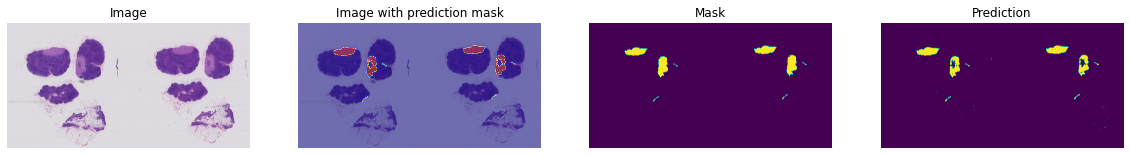

In [ ]:
level = 2
batch_size = 32
#tumor_num_test = [81,84,91,94]+[96,101,110]
#tumor_num_test = [84,91,110]
tumor_num_test = [101]
tumor_num_test = [str(i).zfill(3) for i in tumor_num_test]
Final_ROC = draw_prediction(tumor_num_test, level_img=level, batch_size=batch_size)

In [2]:
 (41572498 + 917364042)/  (41572498 + 6444790 + 917364042 + 1405742)

0.9918797714332697